In [1]:
import os 
from tifffile import imread, imsave
import numpy as np
import matplotlib.pyplot as plt
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Config (change here)
```
basedir: basedir of models for each type of image.  
model_name: 'care', 'dncnn', 'resnet', 'n2n', 'n2v', 'pn2v',   
            'struct_n2v_1x3', 'struct_n2v_1x5', 'struct_n2v_1x9',  
            'struct_n2v_3x1', 'struct_n2v_5x1', or 'struct_n2v_9x1'.  
test_img_path: the path of test images.
save_path: the path to save denoised images.
multi_frames: whether there are multi frames in an image.
```

In [2]:
from os import path

basedir = 'models/models_ast/'           
model_name = 'care'                      
test_img_path = 'test_images/AST/raw/'
save_path = 'denoised/'
multi_frames = False

if not path.exists(save_path):
    os.mkdir(save_path)

### Load test images

In [3]:
def cut_off(img_, max_value):
    img = np.copy(img_)
    img = img.astype('float32')
    mask = img > max_value
    img[mask] = max_value
    img = img / max_value * 1.0
    return img

In [4]:
test_imgs = []
files = os.listdir(test_img_path)

for file in files:
    print('loading ' + file)
    image = imread(test_img_path + file)
    max_value = np.percentile(image, 99.5)
    test_imgs.append(cut_off(image, max_value))
assert len(files) == len(test_imgs)
if multi_frames is False:
    test_imgs = np.stack(test_imgs)
print('done')

loading AST_013_Spock_870nm_ch1_16x_Z8_FLIIP.tif
loading AST_039_Spock_870nm_ch1_16x_Z6_FLIIP.tif
loading AST_044_Spock_870nm_ch1_16x_Z6_FLIIP.tif
loading AST_053_Spock_870nm_ch1_16x_Z8_FLIIP.tif
loading AST_056_Spock_870nm_ch1_16x_Z8_FLIIP.tif
done


### Load models

In [5]:
from csbdeep.models import CARE
from n2v.models import N2V
from nets.dncnn import DnCNN
from nets.resnet import ResNet
import torch

import sys
sys.path.append("nets")
import unet
from pn2v import prediction


model = None
if model_name == 'care':
    print('loading CARE.')
    model = CARE(config=None, name='care', basedir=basedir)
if model_name == 'n2n':
    print('loading N2N.')
    model = CARE(config=None, name='n2n', basedir=basedir)
if model_name == 'n2v':
    print('loading N2V.')
    model = N2V(config=None, name='n2v', basedir=basedir)
if model_name.startswith('struct'):
    print('loading {}'.format(model_name))
    model = N2V(config=None, name=model_name, basedir=basedir)
if model_name == 'pn2v':
    print('loading PN2V.')
    model = torch.load('{}/pn2v/save_model/last_PN2V.net'.format(basedir), map_location=torch.device('cpu'))
if model_name == 'dncnn':
    print('loading DnCNN.')
    model = DnCNN(bias=False)
    model.load_state_dict(torch.load('{}/dncnn/dncnn.pt'.format(basedir), map_location=device))
    model.eval()
if model_name == 'resnet':
    print('loading ResNet.')
    model = ResNet()
    model.load_state_dict(torch.load('{}/resnet/resnet.pt'.format(basedir), map_location=device))
    model.eval()

Using TensorFlow backend.


loading CARE.
Loading network weights from 'weights_best.h5'.


### Predict and save predicted images

In [6]:
def custom_predict(imgs, model_name):
    preds = None
    if imgs.ndim == 2:
        imgs = imgs[np.newaxis,...]
    elif model_name in ['care', 'n2n']:
        imgs = imgs[...,np.newaxis]
        preds = model.keras_model.predict(imgs)[...,0]
    elif model_name == 'n2v' or model_name.startswith('struct'):
        preds = np.zeros(imgs.shape)
        for i in range(imgs.shape[0]):
            preds[i,...] = model.predict(imgs[i], axes='YX')
    elif model_name in ['dncnn', 'resnet']:
        imgs = np.expand_dims(imgs, axis=1)
        imgs = torch.as_tensor(imgs.astype('float32'))
        preds = model(imgs).detach().numpy()[:,0,...] 
    elif model_name == 'pn2v':
        imgs = imgs.astype('float32')
        preds = np.zeros(imgs.shape)
        for i in range(imgs.shape[0]):
            preds[i,...] = prediction.tiledPredict(imgs[i], model, ps=256, overlap=48, device=device, noiseModel=None)
    else:
        raise Exception("Wrong model name!")
    return preds

In [7]:
since = time.time()
if multi_frames is False: 
    preds = custom_predict(test_imgs, model_name)
    preds = np.clip(preds, 0, 1)
    assert preds.shape[0] == len(files)
    for i,file in enumerate(files):
        imsave(save_path+file, preds[i])
else:
    for i in range(len(test_imgs)):
        pred = custom_predict(test_imgs[i], model_name)
        pred = np.clip(pred, 0, 1)
        if pred.shape[0] == 1:
            pred = pred[0]
        imsave(save_path+files[i], pred)

print('Finished denoising. Time: %.2fs'%(time.time()-since))    
print("Denoised images are saved to {}".format(save_path))

Finished denoising. Time: 2.13s
Denoised images are saved to denoised/


### Visualization

Text(0.5, 1.0, 'prediction')

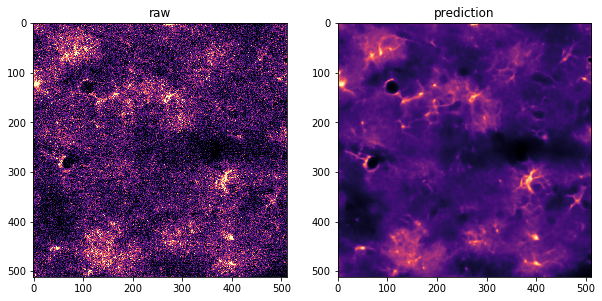

In [8]:
# direct visualization by comparing raw and prediction
filename = 'AST_013_Spock_870nm_ch1_16x_Z8_FLIIP.tif'     # changed here
cmap = 'magma'                                            # ['magma', 'gray', ...]

idx = files.index(filename)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_imgs[idx], cmap=cmap)
plt.title('raw')
plt.subplot(1,2,2)
plt.imshow(preds[idx], cmap=cmap)
plt.title('prediction')

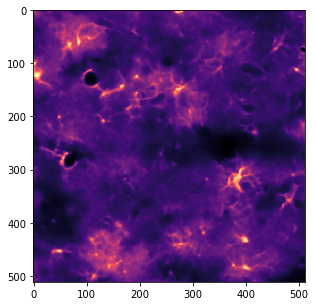

In [9]:
# visualize from saved predictions
filename = 'AST_013_Spock_870nm_ch1_16x_Z8_FLIIP.tif'        # changed here
cmap = 'magma'                                               # ['magma', 'gray', ...]

x = imread(save_path + filename)
plt.figure(figsize=(5,5))
plt.imshow(x, cmap=cmap)